In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import networkx as nx
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
%matplotlib inline

# BPDC

(1, 20000)
(100, 100)


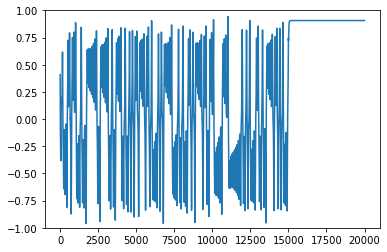

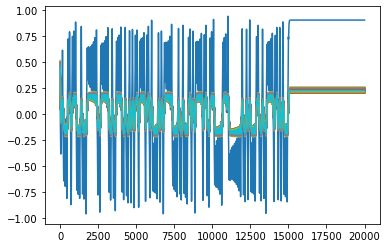

In [467]:
Nx = 100
dt = 1
lr = 0.1
eps = 1e-6
K = 0.999
seed = 42

x = np.random.random((Nx,1))
e = np.zeros((Nx,1))
W = np.random.random((Nx,Nx))
# g = nx.erdos_renyi_graph(Nx, 0.1, seed, True)
# W = np.asarray(nx.adjacency_matrix(g).todense())
f = np.tanh
df = lambda x:1-np.square(np.tanh(x))


system_name1 = 'Lorenz'
U1 = np.loadtxt('dataset/matlab_gendata/'+system_name1+'.csv', delimiter=',').T[0]
# system_name2 = 'Rossler'
# U2 = np.loadtxt('dataset/matlab_gendata/'+system_name2+'.csv', delimiter=',').T[0]
# U = np.vstack([U1,U2])
U= U1
U = U + np.random.randn(*U.shape)*1e-3
U = np.atleast_2d(U)
print(U.shape)
Nu = U.shape[0]
T = U.shape[1]

largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K
print(W.shape)

X = np.zeros((Nx,T))
for t in range(T):
#     x[:Nu] = U[:,t:t+1]
    fs = f(x)
    x = (1-dt)* x + dt * W @ fs
    X[:,t:t+1] = x
    
    # update
    if t < 15000:
        D = np.diag(df(x).flatten())
        dW = ((1-dt)*np.eye(Nx) + dt*W@D)@e
        e[:Nu] = x[:Nu] - U[:,t:t+1]
        dW -= e
        dW = dW @ fs.T/dt/(eps+fs.T@fs)
        norm = np.sum(np.square(dW))
        dW = dW * lr
        W[0] += dW[0]
        x[:Nu] = U[:,t:t+1]
 

_ = plt.plot(X[0].T)
plt.ylim([-1,1])
plt.figure()
_ = plt.plot(X.T)

# TEST

In [471]:
system_name1 = 'Lorenz'
U1 = np.loadtxt('dataset/matlab_gendata/'+system_name1+'.csv', delimiter=',').T[0]
# system_name2 = 'Rossler'
# U2 = np.loadtxt('dataset/matlab_gendata/'+system_name2+'.csv', delimiter=',').T[0]
# U = np.vstack([U1,U2])
U= U1
U = U + np.random.randn(*U.shape)*1e-3
U = np.atleast_2d(U)
print(U.shape)

Nu = U.shape[0]
T = U.shape[1]
Ny = 1
Nx = 100
dt = 0.1
lr = 0.01
eps = 1e-6
K = 1.5
seed = 42

batchsize=100

x = np.random.random((Nx,1))
e = np.zeros((Nx,1))
W = np.random.random((Nx,Nx))
# g = nx.erdos_renyi_graph(Nx, 0.1, seed, True)
# W = np.asarray(nx.adjacency_matrix(g).todense())
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K
Win = np.random.random((Nx,Nu+1))*2-1
Sin = np.array([ 1. for _ in range(Nu+1)])
Wout = np.random.random((Ny,Nx+1))*2-1
B = np.random.random((Ny,Nx+1))*2-1
f = np.tanh
df = lambda x:1-np.square(np.tanh(x))

X = np.zeros((Nx,T))
Y = np.zeros((Ny,T))
dWout = 0
dWin = 0
dSin = 0
dW = 0
m1, v1, ite1 = 0, 0, 0
m2, v2, ite2 = 0, 0, 0
m3, v3, ite3 = 0, 0, 0
G = getNum(1,100)
for epoch in range(1000):
    E = []
    for t in range(T):
        u = np.vstack([1,U[:,t:t+1]])
        fs = f(W @ x + Win @ np.diag(Sin) @ u)
        x = (1-dt)* x + dt * fs
        h = np.vstack([1,x])
        y = Wout @ h
        X[:,t:t+1] = x
        Y[:,t:t+1] = y
        
        e = np.sum(np.square(U[:Ny,t+1:t+2] - y))
        E.append(e)
        # update
        if t < 15000 and t%50 == 0:
            tag = G.get()
            dy = U[:Ny,t+1:t+2] - y
            if tag == 0:
#                 print('update Wout')
                dWout = dy @ h.T
                delta1, m1, v1, ite1 = adam(dWout, m1, v1, ite1, stepsize=0.01)
                Wout += delta1
            elif tag == 1:
#                 print('update Win')
                dSin = (Win.T @ ((B.T @ dy)[1:] * (1-fs**2))/u * dt).flatten()
                delta2, m2, v2, ite2 = adam(dSin, m2, v2, ite2,stepsize=0.01)
                Sin += delta2
#                 dWin = ((Wout.T @ dy)[1:] * (1-fs**2)) @ u.T * dt
#                 delta2, m2, v2, ite2 = adam(dWin, m2, v2, ite2,stepsize=0.01)
#                 Win += delta2
            else:
#                 print('update W')
                dW = ((Wout.T @ dy)[1:] * (1-fs**2)) @ x.T * dt
                delta3, m3, v3, ite3 = adam(dW, m3, v3, ite3,stepsize=0.01)
                W += delta3
            

#     H = np.vstack((np.ones((1,10000)),X[:,:10000]))
#     Wout = U[:Ny,1:10000+1] @ H.T @ np.linalg.inv( H @ H.T + eps*np.eye(H.shape[0]))
    print(np.sum(E))
    
#     if epoch %10 == 0:
#         plt.bar([0,1,2],abs(Sin))
#         plt.show()

    

(1, 20000)
9764.942499706483
978.5837672156517
1127.1861449896226
1146.3234971177067
1182.8389261231614
1204.786551085786
1244.7854161894793
1314.3909709314937
1390.5030067128937
1446.5356921859225
1478.279334788328
1492.8753587386918
1497.375019699319
1496.1972524914943
1491.7770734694336
1485.404753299068
1477.7563719366547
1469.1856977989437
1459.8783260943806
1449.9318728835224
1439.3974430399473
1428.3010550358217
1416.654773317271
1404.4625905380035
1391.7236514316828
1378.4341467098452
1364.588559442157
1350.1806187841637
1335.2041510176607
1319.6539352179277
1303.526629000971
1286.8218072222066
1269.5431417259529
1251.6997367476322
1233.3076181905558
1214.3913527862799
1194.9857430341963
1175.137504887268
1154.9067884174701
1134.3683512367463
1113.6121486421714
1092.743076661996
1071.8796119478588
1051.1511540805516
1030.6940037192687
1010.6461016910587
991.140884514099
972.3008319123137
954.2314284056284
937.0162777408112
920.7139710854063
905.357040206167
890.9529915212322
87

384.1540104767115
383.18321370584727
382.19505466524186
381.1886967226179
380.1632614251319
379.11782538996874
378.0514168462237
376.9630117837545
375.8515296576066
374.71582858953786
373.55469999930057
372.3668625879098
371.1509555832472
369.9055311444373
368.62904580496354
367.3198508155688
365.9761812255814
364.59614351558133
363.17770156434915
361.7186606982792
360.2166495319949
358.66909926402286
357.0732200413538
355.42597395282877
353.72404415453036
351.9637995759857
350.14125461038464
348.252023167995
346.29126649209707
344.2536342352235
342.1331985307504
339.92338126588254
337.61687562203423
335.2055644462964
332.68044055201614
330.0315382467265
327.2478922426509
324.31755113899817
321.22769015613227
317.96489499401076
314.5157298052946
310.8677617970361
307.0112949397089
302.94215797444446
298.6659635471841
294.20421516237764
289.60229656026036
284.9384273105729
280.3308175711967
275.93773298492385
271.9436592186364
268.5276982151737
265.82030567596814
263.86702342935143
262.

291.2212223003376
291.212302884766
291.20318010307534
291.1938548448615
291.1843279980759
291.1746004489626
291.16467308215965
291.1545467805536
291.1442224253669
291.1337008960734
291.1229830704701
291.11206982458367
291.10096203268745
291.0896605673105
291.07816629920626
291.0664800973608
291.0546028289548
291.04253535935254
291.0302785521074
291.01783326895685
291.0052003698171
290.99238071275624
290.97937515396535
290.9661845477814
290.95280974672124
290.9392516013342
290.9255109603198
290.91158867054247
290.8974855768405
290.88320252227635
290.8687403478351
290.8540998927133
290.83928199408354
290.8242874871987
290.809117205392
290.79377197999804
290.7782526403844
290.7625600139793
290.7466949261883
290.73065820046793
290.7144506582757
290.6980731190886
290.68152640029643
290.66481131740227
290.647928683795
290.6308793109216
290.6136640081261
290.5962835827818
290.57873884019807
290.5610305836575
290.5431596143886
290.5251267315699
290.50693273230553
290.48857841171355
290.4700645

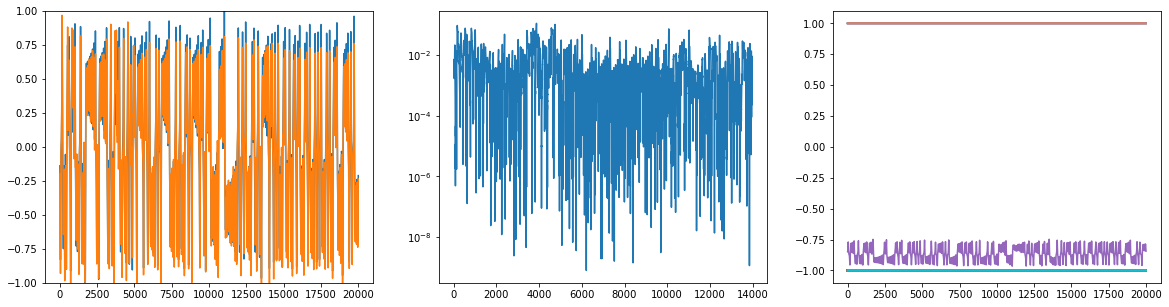

In [434]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
_ = plt.plot(U[0].T)
_ = plt.plot(Y[0].T)

plt.ylim([-1,1])
plt.subplot(1,3,2)
plt.plot(E)
plt.yscale('log')


plt.subplot(1,3,3)
plt.plot(X.T)
#     plt.bar([0,1,2],np.sum(abs(Win),axis=0))
plt.show()

In [410]:
class getNum:
    def __init__(self, classes, num):
        self.classes = classes
        self.num = num
        self.queue = [ a for a in range(classes) for _ in range(self.num)]
        self.index = -1
    
    def get(self,):
        self.index = (self.index+1)%len(self.queue)
        return self.queue[self.index]


In [438]:
X

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [345]:
for _ in range(1000):
    E = []
    for t in range(T):
        u = np.vstack([1,U[:,t:t+1]])
        fs = f(W @ x + Win @ u)
        x = (1-dt)* x + dt * fs
        h = np.vstack([1,x])
        y = Wout @ h
        X[:,t:t+1] = x
        Y[:,t:t+1] = y
        
        e = np.sum(np.square(U[:Ny,t+1:t+2] - y))
        E.append(e)
        # update
        if t < 15000:
            dy = U[:Ny,t+1:t+2] - y
            dWout += dy @ h.T - eps*Wout
            dWin += ((Wout.T @ dy)[1:] * (1-fs**2)) @ u.T * dt
            if t % batchsize == 1:

                delta1, m1, v1, ite1 = adam(dWout, m1, v1, ite1,stepsize=0.005)
                Wout += delta1
                delta2, m2, v2, ite2 = adam(dWin, m2, v2, ite2,stepsize=0.005)
                Win += delta2         
#                 Wout += lr*dWout
#                 Win += lr*dWin

        
    
#     H = np.vstack((np.ones((1,10000)),X[:,:10000]))
#     Wout = U[:Ny,1:10000+1] @ H.T @ np.linalg.inv( H @ H.T + eps*np.eye(H.shape[0]))
    print(np.sum(E))


1029.3120496616345
950.4954825793232
914.2897700215062
956.5807727575693
981.946133428753
943.1583568235483
925.682649818572
947.1370584905944
971.4648089837308
996.5964427112116
1003.664770809821
1004.4993376477435
1005.1867889356198
986.0469370299511
965.2155949105875
963.351339120984
981.3090500545363
1018.7270546990679
1066.1658952187267
1107.6725969930576
1077.501582224859
835.7519189088432
818.7774873415453
1109.1318469765274
1216.1951269196832
996.1569529498495
854.1175472309914
883.4005180693135
871.5918461989024
827.5836641761011
837.2871265038315
903.335087088481
938.9695690855142
999.7288056089122
1015.4493366284852
1007.8949822924798
1005.5074088801639
1026.7799965454292
1046.8166642241338
1019.735505942919
943.7973626495705
941.105774004507
923.2459257915905
913.9144410835847
912.7999094098913
901.3370276425087
873.8016632678791
832.6696152927898
781.9733027632318
736.9805224727422
718.2745782761953
736.8775143195562
772.4729002848378
777.4480842662377
752.8900168116502
74

785.9246997735468
716.1498420998303
686.2550040216157
928.070373535444
754.4544780648237
723.4883426150709
671.3805471779939
764.6002126083698
757.4453082861994
745.5357015733146
840.0845225301065
990.3667061131655
694.9529923679379
777.4716214562516
962.5782770900075
796.6123036194164
776.1407784208951
751.32112539648
760.2110092540918
958.4188959814134
942.1552158714267
795.0419915160387
801.2899178226974
796.8743884945948
867.7941358944556
931.3041585295186
817.9103357176406
829.2168929218493
671.7150182899086
1052.1916603410657
799.7172975957462
767.2223264374227
598.3826504880744
730.750114173826
833.6501043395986
756.6085621318965
811.1896048058859
856.0009754207799
553.7354880672299
624.0403730246444
801.0123485356685
880.6868333302876
636.0562309750421
888.0303488233891
856.0030860965617
735.2834318527464
813.1427136692241
690.2357151087267
791.834966454176
836.0438932375803
2197.455944655231
967.0271723921069
614.8404853657307
508.9763208225173
569.429243817352
509.91703498710

914.6092845369687
782.5683801144517
709.4204856759764
751.3354533782376
848.5975410012558
686.264500864798
685.4984214109578
657.5688709188753
759.3125687429645
742.0376785496728
769.1632573698292
740.0865464144222
813.9149067071744
781.185322072441
852.4417612661246
738.3029046125508
760.11636735616
834.6673597632492
706.3010565194317
640.3439179033983
681.7035225372764
703.8214724377865
751.7683911150388
739.4779773413824
749.8531301027473
699.3700846510505
886.6029678903956
707.6662205770791
706.9989928385662
694.7264729531626
821.8651992602828
731.554403004385
768.5713372434916
705.1999330746333
862.122906192259
799.1897097288485
724.976829991035
696.9637174464198
765.3087035361974
752.950301017273
710.9391632459485
672.4169128550194
731.2876560811544
735.3155168711849
638.9094042037441
710.8027840677559
741.2015798167106
725.3145986940888
664.0308974574168
733.9359730645587
700.3088601138076
669.6310180277276
715.9941505042506
711.8073195010234
742.2273658675258
803.1974027132649


In [346]:
Tgen = 1000
Ygen = np.zeros((Ny,Tgen))
for t in range(T):
    u = np.vstack([y,1])
    fs = f(W @ x + Win @ u)
    x = (1-dt)* x + dt * fs
    h = np.vstack([1,x])
    y = Wout @ h
    Ygen[:,t:t+1] = y
_ = plt.plot(Ygen[0].T)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

<BarContainer object of 3 artists>

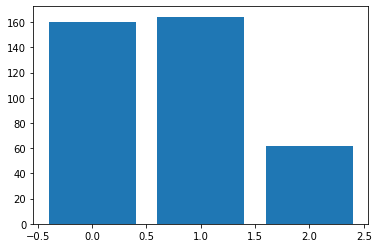

In [347]:
plt.bar([0,1,2],np.sum(abs(Win),axis=0))

# gradient decent

In [79]:
def adam(g, m, v, t, b1=0.9, b2=0.999, stepsize=0.01, eps=1e-8, clip = 1):
    m = (1 - b1) * g      + b1 * m    # First  moment estimate.
    v = (1 - b2) * (g**2) + b2 * v    # Second moment estimate.
    mhat = m / (1 - b1**(t + 1))    # Bias correction.
    vhat = v / (1 - b2**(t + 1))
    delta = (lr * mhat) / (np.sqrt(vhat) + eps)
    norm = np.sum(np.square(delta))
    if norm > clip:
        delta /= norm
    return delta, m, v, t+1

def rms_prop(g, avg_sq_grad, gamma=0.9, eps=1e-8, lr=0.01):
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)  # rmsprop
    delta = g / (np.sqrt(avg_sq_grad) + eps)
    return lr*delta

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma



(4, 20000)
436


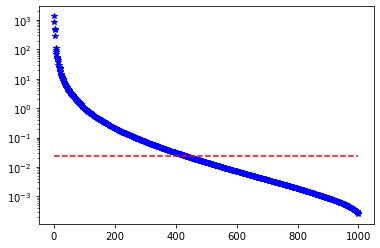

pre_output shape: (437, 10000)
W_out shape: (4, 437)
train err:  0.44021992323834774


In [147]:
system_name1 = 'Lorenz'
U1 = U_pendulum
# U1 = np.loadtxt('dataset/matlab_gendata/'+system_name1+'.csv', delimiter=',').T[0]
# system_name2 = 'Rossler'
# U2 = np.loadtxt('dataset/matlab_gendata/'+system_name2+'.csv', delimiter=',').T[0]
# U = np.vstack([U1,U2])
U= U1
# U = U + np.random.randn(*U.shape)*1e-3
U = np.atleast_2d(U)
print(U.shape)

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000




Nu = U.shape[0]
T = U.shape[1]
Ny = Nu
Nx = 1000
dt = 0.1
lr = 0.01
eps = 1e-8
K = 1
seed = 42

x = np.random.random((Nx,1))
e = np.zeros((Nx,1))
# W = np.random.random((Nx,Nx))
g = nx.erdos_renyi_graph(Nx, 0.01, seed, True)
W = np.asarray(nx.adjacency_matrix(g).todense())
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K
Win = np.random.random((Nx,Nu+1))*2-1

f = np.tanh
df = lambda x:1-np.square(np.tanh(x))

X = np.zeros((Nx,T))

for t in range(T):
    u = np.vstack([1,U[:,t:t+1]])
    x = (1-dt)* x + dt * f(W @ x + Win @ u)
    X[:,t:t+1] = x

# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = U[:,train_start + 1 : train_start + num_train + 1]

Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
tau = svht(X_train, sv=Diag)
Nv = np.sum(Diag>tau)
print(Nv)

plt.figure()
plt.plot(Diag, 'b*', label='sigular values')
plt.plot([0,len(Diag)],[tau,tau], 'r--', label=r'$\sigma$ unknown')
plt.yscale('log')

plt.show()

MlT, Diag, Mr = Ml.T[:Nv], Diag[:Nv], Mr[:Nv]

# H = np.vstack((np.ones((1,X_train.shape[1])),  X_train))
# Wout = np.random.random((Ny,Nx+1))*2-1
H = np.vstack((np.ones((1,X_train.shape[1])), MlT @ X_train))
Wout = np.random.random((Ny,Nv+1))*2-1

# Ridge Regresion
Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + eps*np.eye(H.shape[0]))

# gradient descent
# m1, v1, ite1 = 0,0,0
# for epoch in range(10000):
#     dWout = (Y_train - Wout @ H) @ H.T
#     delta1, m1, v1, ite1 = adam(dWout, m1, v1, ite1, b1=0.9, b2=0.999,stepsize=0.1)
#     Wout += delta1
#     if epoch % 1000 == 0:
#         print('epoch: {} train err: {}'.format(epoch,np.sum(np.square(Y_train - Wout @ H))))

print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)  
print('train err: ',np.sum(np.square(Y_train - Wout @ H)))
    

(4, 20000)


  0%|          | 0/10 [00:00<?, ?it/s]

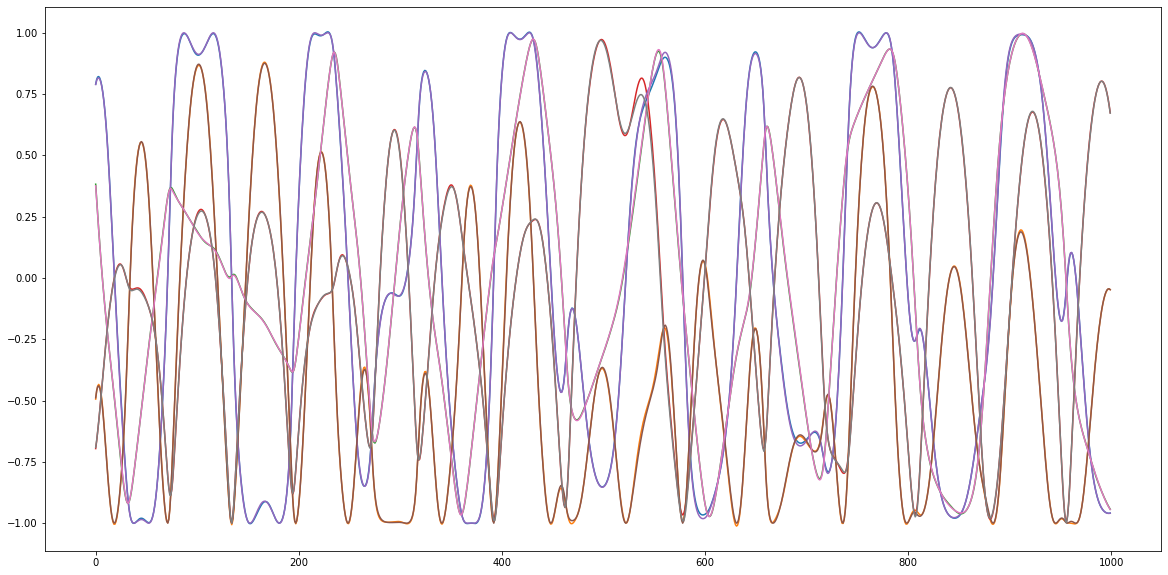

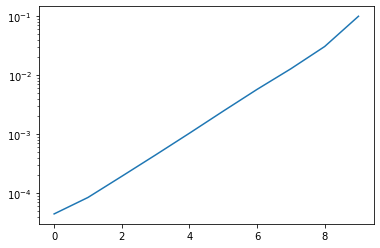

In [169]:
horizon = 1
num_test = 1000
pred = []
print(U.shape)

U_test = U[:,test_start : test_start + num_test]
X_test = X[:,test_start : test_start + num_test]
H = np.vstack((np.ones((1,num_test)), MlT @ X_test))
Y_pred = Wout @ H

plt.figure(figsize=(20,10))
plt.plot(Y_pred.T)
plt.plot(U[:,test_start+1 : test_start + num_test+1].T)


horizon = 10
mses = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-dt) * X_test + dt * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
    H = np.vstack((np.ones((1,num_test)),MlT @ X_test))
    Y_pred = Wout @ H
    Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
    mses.append(np.average(np.square(Y_pred - Y_true)))

plt.figure()
plt.plot(mses)
plt.yscale('log')

In [144]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 400  # how many seconds to simulate


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.02
t = np.arange(0, t_stop, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])
x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

U_pendulum = np.vstack([x1,y1,x2,y2])
pmax, pmin = np.max(U_pendulum,axis=1),np.min(U_pendulum,axis=1)
U_pendulum = np.diag(1./(pmax - pmin)) @ (U_pendulum - pmin.reshape((-1,1))) *2 -1

print(U_pendulum.shape)

(4, 20000)
